In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Data loading and preprocessing

In [2]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_valid, y_valid, X_train, y_train = X_train[:10000]/255.0, y_train[:10000], X_train[10000:]/255.0, y_train[10000:]
X_test = X_test/255.0
X_train.min(), X_train.max(), X_valid.min(), X_valid.max(), X_test.min(), X_test.max()

170508288/170498071 [==============================] - 3s 0us/step


(0.0, 1.0, 0.0, 1.0, 0.0, 1.0)

In [3]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((40000, 32, 32, 3),
 (10000, 32, 32, 3),
 (10000, 32, 32, 3),
 (40000, 1),
 (10000, 1),
 (10000, 1))

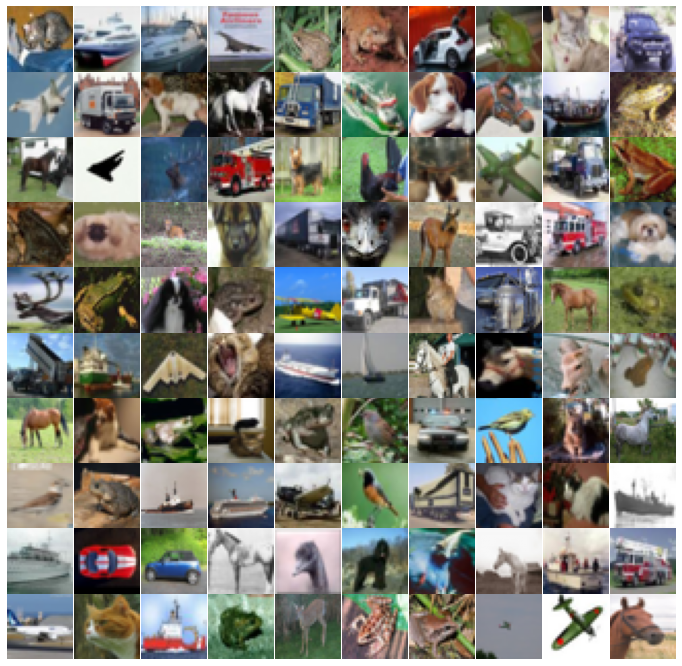

In [4]:
num_rows, num_cols = 10, 10
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for row in range(num_rows):
    for col in range(num_cols):
        axs[row, col].imshow(X_test[count])
        axs[row, col].axis("off")
        count += 1
plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
plt.show()

# Blurring the images

In [5]:
from scipy.ndimage import gaussian_filter
blurred_X_train = gaussian_filter(X_train, sigma = 0.6)
blurred_X_valid = gaussian_filter(X_valid, sigma = 0.6)
blurred_X_test = gaussian_filter(X_test, sigma = 0.6)

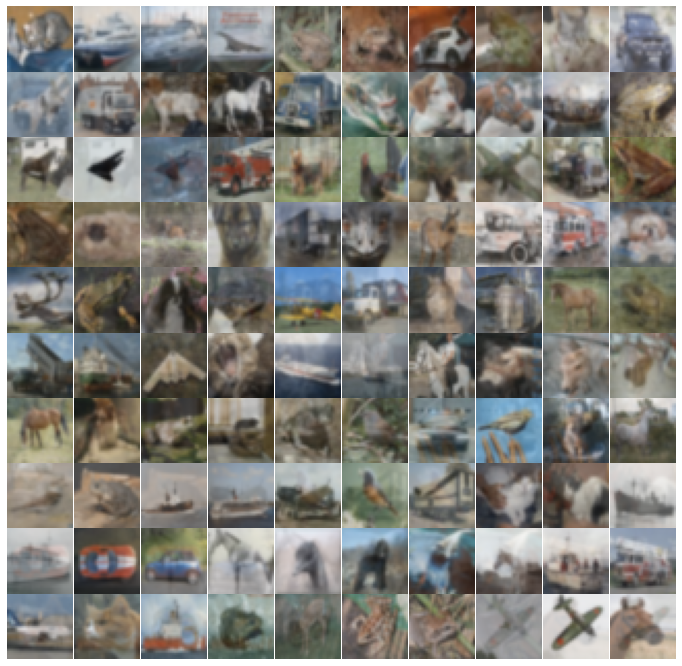

In [6]:
num_rows, num_cols = 10, 10
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for row in range(num_rows):
    for col in range(num_cols):
        axs[row, col].imshow(blurred_X_test[count])
        axs[row, col].axis("off")
        count += 1
plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
plt.show()

# Defining and training the model

In [11]:
encoder = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size = 3, strides = 2, padding = "same",
                       activation = "relu", kernel_initializer = "he_normal",
                       input_shape = [32, 32, 3]),
    keras.layers.Conv2D(64, kernel_size = 3, strides = 2, padding = "same",
                       activation = "relu", kernel_initializer = "he_normal",),
    keras.layers.Conv2D(128, kernel_size = 3, strides = 2, padding = "same",
                       activation = "relu", kernel_initializer = "he_normal",),
    keras.layers.Conv2D(256, kernel_size = 3, strides = 1, padding = "same",
                       activation = "relu", kernel_initializer = "he_normal",)
])
encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 256)         295168    
Total params: 388,416
Trainable params: 388,416
Non-trainable params: 0
_________________________________________________________________


In [12]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(128, kernel_size = 3, strides = 1, padding = "same",
                                activation = "relu", kernel_initializer = "he_normal",
                                input_shape = [4, 4, 256]),
    keras.layers.Conv2DTranspose(64, kernel_size = 3, strides = 2, padding = "same",
                                activation = "relu", kernel_initializer = "he_normal",),
    keras.layers.Conv2DTranspose(32, kernel_size = 3, strides = 2, padding = "same",
                                activation = "relu", kernel_initializer = "he_normal",),
    keras.layers.Conv2DTranspose(3, kernel_size = 3, strides = 2, padding = "same",
                                activation = "sigmoid", kernel_initializer = "glorot_normal")
])
decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 3)         867       
Total params: 388,163
Trainable params: 388,163
Non-trainable params: 0
_________________________________________________________________


In [13]:
denoising_ae = keras.models.Sequential([encoder, decoder])
denoising_ae.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 4, 4, 256)         388416    
_________________________________________________________________
sequential_5 (Sequential)    (None, 32, 32, 3)         388163    
Total params: 776,579
Trainable params: 776,579
Non-trainable params: 0
_________________________________________________________________


In [14]:
denoising_ae.compile(loss = "binary_crossentropy",
                     optimizer = keras.optimizers.SGD(learning_rate = 0.5,
                                                  momentum = 0.9,
                                                  nesterov = True),
                    #seems like Adam is not good for this task
                    metrics = ["accuracy"])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("so_far_best.h5", save_best_only = True, verbose = 1)
history = denoising_ae.fit(
    blurred_X_train, X_train,
    epochs = 1000,
    validation_data = (blurred_X_valid, X_valid),
    callbacks = [checkpoint,
                 keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)]
)

2022-10-18 14:55:55.728978: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


2022-10-18 14:55:57.192815: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - 15s 6ms/step - loss: 0.6040 - accuracy: 0.5023 - val_loss: 0.5831 - val_accuracy: 0.6207

Epoch 00001: val_loss improved from inf to 0.58309, saving model to so_far_best.h5
Epoch 2/1000
1250/1250 [==============================] - 7s 5ms/step - loss: 0.5821 - accuracy: 0.6150 - val_loss: 0.5769 - val_accuracy: 0.6148

Epoch 00002: val_loss improved from 0.58309 to 0.57690, saving model to so_far_best.h5
Epoch 3/1000
1250/1250 [==============================] - 7s 5ms/step - loss: 0.5783 - accuracy: 0.6229 - val_loss: 0.5754 - val_accuracy: 0.6392

Epoch 00003: val_loss improved from 0.57690 to 0.57537, saving model to so_far_best.h5
Epoch 4/1000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5762 - accuracy: 0.6278 - val_loss: 0.5748 - val_accuracy: 0.6529

Epoch 00004: val_loss improved from 0.57537 to 0.57475, saving model to so_far_best.h5
Epoch 5/1000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.

In [16]:
denoising_ae.evaluate(X_test, X_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6033 - accuracy: 0.7949


[0.6032629609107971, 0.7948753833770752]

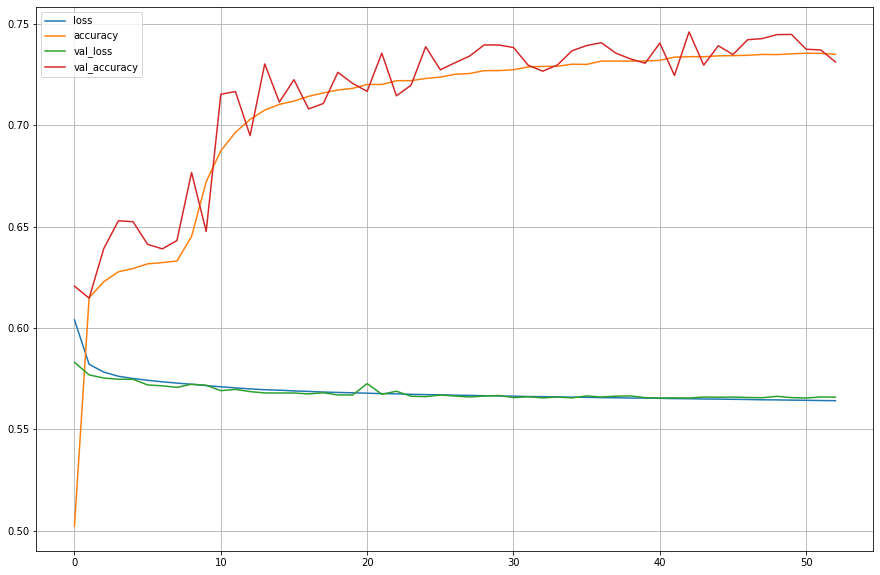

In [17]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize = (15, 10))
plt.grid(True)
plt.show()

In [18]:
latent_repr = encoder.predict(blurred_X_test[:36])
reconstructions = decoder.predict(latent_repr)

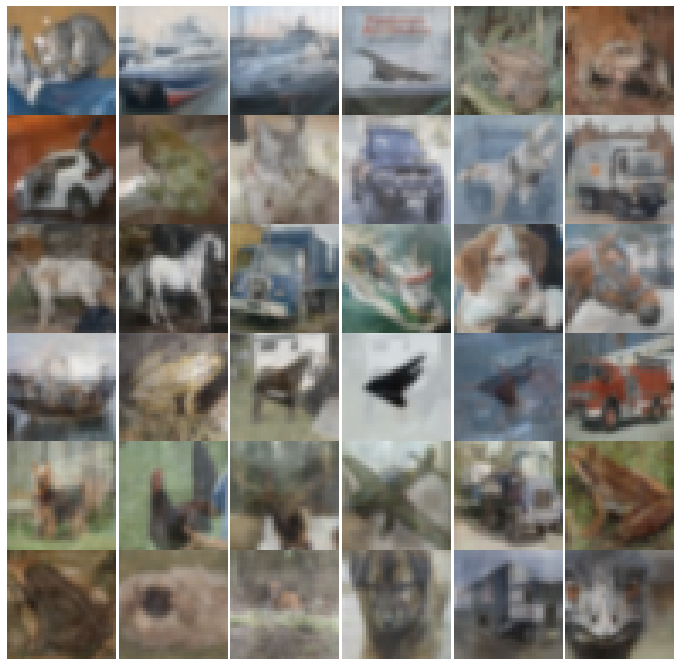

In [19]:
num_rows, num_cols = 6, 6
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for row in range(num_rows):
    for col in range(num_cols):
        axs[row, col].imshow(blurred_X_test[count])
        axs[row, col].axis("off")
        count += 1
plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
plt.show()

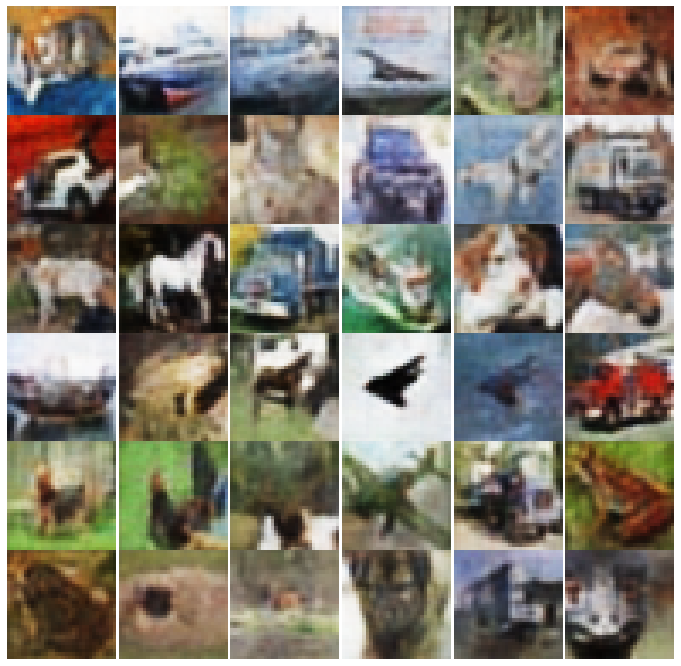

In [20]:
num_rows, num_cols = 6, 6
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for row in range(num_rows):
    for col in range(num_cols):
        axs[row, col].imshow(reconstructions[count])
        axs[row, col].axis("off")
        count += 1
plt.subplots_adjust(wspace = 0.0, hspace = 0.0)
plt.show()